## 타이타닉 전처리기

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('data/titanic_train.csv')
y = train['Survived']
X = train.drop('Survived', axis = 1)

In [3]:
def fillna(data):
    data['Age'].fillna(np.mean(data['Age']), inplace=True)
    data['Cabin'].fillna('N', inplace=True)
    data['Embarked'].fillna('N', inplace=True)
    data['Fare'].fillna(0, inplace=True)
    return data


def add_features(data):
    def get_category(age):
        cat = ''
        if age <= -1: cat = 'Unknown'
        elif age <= 5: cat = 'Baby'
        elif age <= 12: cat = 'Child'
        elif age <= 18: cat = 'Teenager'
        elif age <= 25: cat = 'Student'
        elif age <= 35: cat = 'Young Adult'
        elif age <= 60: cat = 'Adult'
        else: cat = 'Elderly'
        
        return cat
    
    data['Age_cat'] = data['Age'].apply(get_category)
    
    data['title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)
    
    def get_title_cat(title):
        title_cat = ['Mr', 'Mrs', 'Miss']
        if title not in title_cat:
            return 'Others'
        else:
            return title
    
    data['title'].apply(lambda x : get_title_cat(x))
    
    data["Family_size"] = data['SibSp']+data["Parch"] + 1
    data.drop(['SibSp', 'Parch'], axis = 1, inplace=True)
    
    return data
    
def drop_features(data):
    data.drop(['PassengerId', 'Name', 'Ticket','Age'], axis=1, inplace=True)
    return data

def format_features(data):
    data['Cabin'] = data['Cabin'].str[:1]
    columns = ['Sex', 'Embarked', 'title', 'Age_cat', 'Cabin']
    
    for feature in columns:
        le = LabelEncoder()
        le.fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data

def transform_features(data):
    data = fillna(data)
    data = add_features(data)
    data = drop_features(data)
    data = format_features(data)
    
    return data

In [4]:
X = transform_features(X)

In [5]:
X

,Pclass,Sex,Fare,Cabin,Embarked,Age_cat,title,Family_size
0,3,1,7.2500,7,3,4,12,2
1,1,0,71.2833,2,0,0,13,2
2,3,0,7.9250,7,3,6,9,1
3,1,0,53.1000,2,3,6,13,2
4,3,1,8.0500,7,3,6,12,1
...,...,...,...,...,...,...,...,...
886,2,1,13.0000,7,3,6,15,1
887,1,0,30.0000,1,3,4,9,1
888,3,0,23.4500,7,3,6,9,4
889,1,1,30.0000,2,0,6,12,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=37)

In [7]:
lr_clf = LogisticRegression()

# 분류 평가 지표

### get_clf_eval() 함수

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [9]:
lr_clf.fit(X_train, y_train)

C:\Users\mo223\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
pred = lr_clf.predict(X_test)

In [11]:
get_clf_eval(y_test, pred)

오차행렬
[[87 14]
 [21 57]]
정확도: 0.8045, 정밀도: 0.8028, 재현율: 0.7308


##  정밀도/재현율 트레이드오프

### predict_proba()

In [12]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()결과 Shape : {0}".format(pred_proba.shape))
print("pred_proba array에서 앞 3개만 샘플로 추출\n", pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n", pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
 [[0.89847605 0.10152395]
 [0.91214782 0.08785218]
 [0.83007685 0.16992315]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.89847605 0.10152395 0.        ]
 [0.91214782 0.08785218 0.        ]
 [0.83007685 0.16992315 0.        ]]


## Threshold의 이해

### Binarizer

In [13]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)

print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [14]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custome_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custome_predict)

오차행렬
[[87 14]
 [21 57]]
정확도: 0.8045, 정밀도: 0.8028, 재현율: 0.7308


## threshold 0.4

In [15]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custome_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custome_predict)

오차행렬
[[80 21]
 [18 60]]
정확도: 0.7821, 정밀도: 0.7407, 재현율: 0.7692


## 최적 threshold 찾기

In [17]:
pred_proba

array([[0.89847605, 0.10152395],
       [0.91214782, 0.08785218],
       [0.83007685, 0.16992315],
       [0.91747062, 0.08252938],
       [0.3405065 , 0.6594935 ],
       [0.86268162, 0.13731838],
       [0.85963335, 0.14036665],
       [0.83007685, 0.16992315],
       [0.94521796, 0.05478204],
       [0.4075266 , 0.5924734 ],
       [0.8985031 , 0.1014969 ],
       [0.43712216, 0.56287784],
       [0.47372403, 0.52627597],
       [0.15514271, 0.84485729],
       [0.90315306, 0.09684694],
       [0.55551356, 0.44448644],
       [0.90758272, 0.09241728],
       [0.46732291, 0.53267709],
       [0.06433948, 0.93566052],
       [0.83453189, 0.16546811],
       [0.17985857, 0.82014143],
       [0.25862072, 0.74137928],
       [0.22829129, 0.77170871],
       [0.25794242, 0.74205758],
       [0.83332675, 0.16667325],
       [0.04985089, 0.95014911],
       [0.8986206 , 0.1013794 ],
       [0.88322545, 0.11677455],
       [0.04488643, 0.95511357],
       [0.88322545, 0.11677455],
       [0.

In [18]:
thresholds = np.arange(0.4, 0.65, 0.05)
thresholds = list(thresholds)

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임곗값:", custom_threshold)
        get_clf_eval(y_test,custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[80 21]
 [18 60]]
정확도: 0.7821, 정밀도: 0.7407, 재현율: 0.7692
임곗값: 0.45
오차행렬
[[83 18]
 [19 59]]
정확도: 0.7933, 정밀도: 0.7662, 재현율: 0.7564
임곗값: 0.5
오차행렬
[[87 14]
 [21 57]]
정확도: 0.8045, 정밀도: 0.8028, 재현율: 0.7308
임곗값: 0.55
오차행렬
[[88 13]
 [24 54]]
정확도: 0.7933, 정밀도: 0.8060, 재현율: 0.6923
임곗값: 0.6
오차행렬
[[93  8]
 [27 51]]
정확도: 0.8045, 정밀도: 0.8644, 재현율: 0.6538


## precision_recall_curve()

In [90]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 Shape:", thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임계값 배열의 index 10개:", thr_index)
print("샘플용 10개의 임곗값: ", np.round(thresholds[thr_index], 2))

print("샘플 임계값별 정밀도: ", np.round(precisions[thr_index], 3))
print("샘플 임계값별 재현율: ", np.round(recalls[thr_index],3 ))

반환된 분류 결정 임곗값 배열의 Shape: (139,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.09 0.1  0.14 0.17 0.38 0.53 0.66 0.73 0.88 0.95]
샘플 임계값별 정밀도:  [0.494 0.525 0.598 0.663 0.723 0.794 0.865 0.912 0.947 1.   ]
샘플 임계값별 재현율:  [1.    0.949 0.897 0.859 0.769 0.692 0.577 0.397 0.231 0.051]


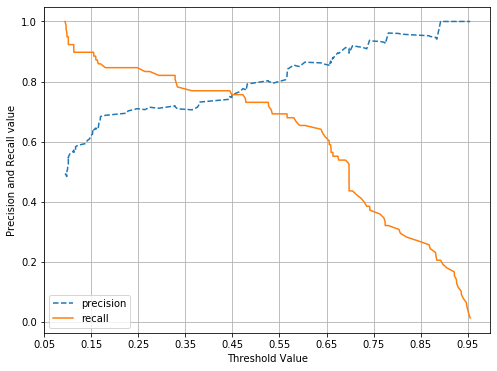

In [94]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label="precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel("Threshold Value"); plt.ylabel("Precision and Recall value")
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

# F1 스코어

In [95]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print("F1 스코어: {0:.4f}".format(f1))

F1 스코어: 0.7651


In [97]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print("오차행렬")
    print(confusion)
    # f1 score print 추가
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}".format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[80 21]
 [18 60]]
정확도: 0.7821, 정밀도: 0.7407, 재현율: 0.7692, F1: 0.7547
임곗값: 0.45
오차행렬
[[83 18]
 [19 59]]
정확도: 0.7933, 정밀도: 0.7662, 재현율: 0.7564, F1: 0.7613
임곗값: 0.5
오차행렬
[[87 14]
 [21 57]]
정확도: 0.8045, 정밀도: 0.8028, 재현율: 0.7308, F1: 0.7651
임곗값: 0.55
오차행렬
[[88 13]
 [24 54]]
정확도: 0.7933, 정밀도: 0.8060, 재현율: 0.6923, F1: 0.7448
임곗값: 0.6
오차행렬
[[93  8]
 [27 51]]
정확도: 0.8045, 정밀도: 0.8644, 재현율: 0.6538, F1: 0.7445


## ROC곡선과 AUC

In [99]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs , tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(1, thresholds.shape[0], 5)

print("샘플 추출을 위한 임곗값 배열의 index 10개:", thr_index)
print("샘플용 10개의 임곗값: ", np.round(thresholds[thr_index], 2))

print("샘플 임곗값별 FPR: ", np.round(fprs[thr_index], 3))
print("샘플 임곗값별 TPR: ", np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71]
샘플용 10개의 임곗값:  [0.96 0.74 0.7  0.66 0.6  0.53 0.44 0.29 0.17 0.16 0.12 0.1  0.1  0.09
 0.05]
샘플 임곗값별 FPR:  [0.    0.02  0.04  0.059 0.079 0.139 0.198 0.257 0.307 0.366 0.495 0.584
 0.663 0.812 1.   ]
샘플 임곗값별 TPR:  [0.013 0.385 0.474 0.551 0.654 0.692 0.769 0.821 0.859 0.872 0.897 0.923
 0.949 1.    1.   ]


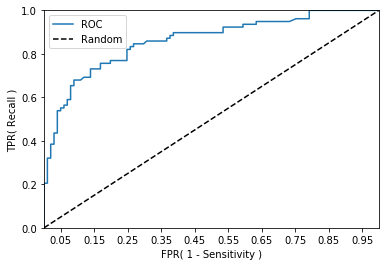

In [100]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel("TPR( Recall )")
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

In [105]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix( y_test, pred))
print("정확도:", np.round(accuracy_score(y_test, pred), 4))
print("정밀도:", np.round(precision_score(y_test, pred), 4))
print("재현률:", np.round(recall_score(y_test, pred), 4))

[[87 14]
 [21 57]]
정확도: 0.8045
정밀도: 0.8028
재현률: 0.7308


In [106]:
def get_clf_eval(y_test, pred = None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차행렬")
    print(confusion)
    # ROC-AUC print 추가
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

In [107]:
get_clf_eval(y_test, pred , pred_proba[:, 1])

오차행렬
[[87 14]
 [21 57]]
정확도: 0.8045, 정밀도: 0.8028, 재현율: 0.7308, F1: 0.7651, AUC:0.8606
